# Energy Conversion Component Tests

## Imports

In [1]:
import pprint
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import copy
from energysys_components.energy_conversion import ECCParameter, ECCState,EnergyConversionComponent
from pathlib import Path
from energysys_components.energy_carrier import ECarrier
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from energysys_components.simulation import Simulation

## Definition of component

In [2]:
path_ecarrier = Path.cwd().parent / Path("energycarrier/energycarrier.yaml")
ec_dict = ECarrier.from_yaml(path_ecarrier)
components = ECCParameter.from_yaml(Path.cwd() / Path("../components/fuel_cell_PEM.yaml"), ecarrier=ec_dict)
component = components["PEM"]

In [3]:
## Initialization of component
component_state = ECCState()
pprint.pprint(component_state)

ECCState(E_bulk=0,
         E_bulk_heatup=0,
         E_bulk_op=0,
         P_in=0,
         E_in=0,
         P_in_mc=0,
         E_in_mc=0,
         P_in_sd1=0,
         E_in_sd1=0,
         P_in_sd2=0,
         E_in_sd2=0,
         P_out=0,
         P_out_target=0,
         E_out=0,
         P_loss=0,
         E_loss=0,
         P_heat=0,
         E_heat=0,
         heatup=0,
         eta=0,
         eta_mc=0,
         opex_Eur=0,
         SoH=1,
         E_balance=0)


In [4]:
timestep_s = 10

In [5]:
C1 = EnergyConversionComponent(par=component,
                      ts=timestep_s,
                     state=component_state)
pprint.pprint(C1)

## Run simple test cases

### Constant target output load from initial state (Stationary Step)

In [6]:
# Result DataFrame Initialization
state_parms = [a for a in dir(ECCState()) if not a.startswith('__')]
df1 = pd.DataFrame(columns=state_parms)
df1.loc[0] = vars(ECCState())

# Run different stationary cases for target output load
targets = np.linspace(0, 1., 100)

for ct, t in enumerate(targets):
    # Initialization of component
    C1_state = ECCState()
    C1 = EnergyConversionComponent(par=component,
                                   ts=timestep_s,
                                   state=copy.deepcopy(C1_state))
    C1.apply_control_stationary(t)
    df1.loc[ct + 1] = vars(C1.state)
    df1.loc[ct + 1, "Target"] = t

# Create traces
fig = go.Figure()

# Create traces
for cl in df1.columns:
    fig.add_trace(go.Scatter(x=df1.Target[1:], y=df1[cl][1:],
                             mode='lines',
                             name=cl))
fig.update_layout(xaxis_title="Target rel. output load [-]",
                  # yaxis_title="Y Axis Title",
                  )
fig.update_layout(
    autosize=False,
    width=800,
    height=800)
fig.show()


## Transient Plot

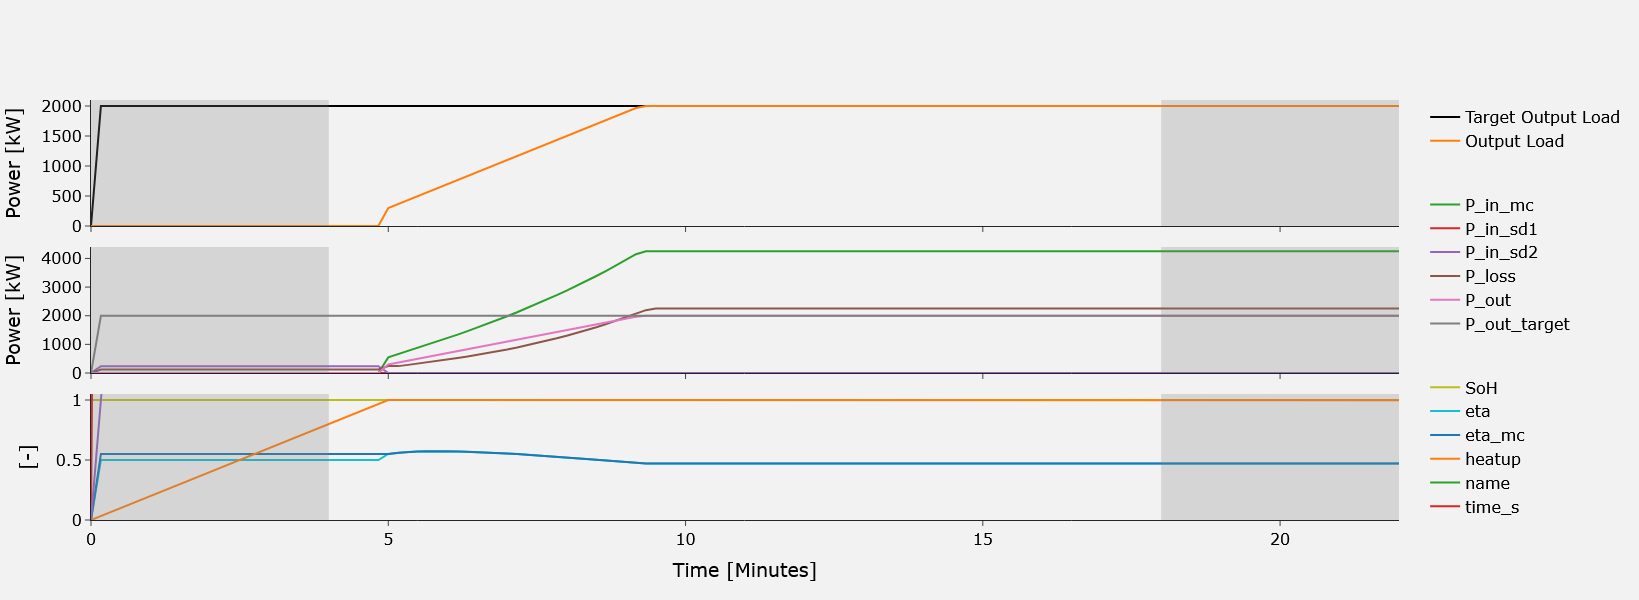

In [7]:
# Load profile
total_time_s = 7200  # number of time steps
n_ts = int(total_time_s/timestep_s)
target = 1

loadprofile = []

for t in range(n_ts):
    if t <= n_ts/2:
        loadprofile.append(target)
    else:
        loadprofile.append(0)

sim = Simulation(component_parameter=component,
                 timestep_s=timestep_s,
                 loadprofile=loadprofile)

sim.run()


fig = make_subplots(rows=3, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.05)


fig.add_trace(go.Scatter(x=sim.results.time_s/60,
                         y=sim.results.P_out_target,
                         line=dict(color="black"),
                                     mode='lines',
                                     name="Target Output Load",
                         legendgroup = '1'),
                         row=1, col=1)
fig.add_trace(go.Scatter(x=sim.results.time_s/60,
                         y=sim.results.P_out,
                                     
                                     mode='lines',
                                     name="Output Load",
                         legendgroup = '1'),
                         row=1, col=1)

# Create traces
for cl in sim.results.columns :
    if not cl[:2] =="E_" and not cl[:3]=="err"and not cl[:4]=="opex":
        if cl[0]== "P": # and (not cl=="P_heat") :
            if cl=="P_heat" or cl=="P_in":
                pass

            else: 
                fig.add_trace(go.Scatter(x=sim.results.time_s/60, y=sim.results[cl][:],
                         
                         mode='lines',
                         name=cl,
                         legendgroup = '2'),
                     row=2, col=1)

        else:
            fig.add_trace(go.Scatter(x=sim.results.time_s/60, y=sim.results[cl][:],
                         
                         mode='lines',
                         name=cl,
                          legendgroup = '3'),
                         row=3, col=1)



fig.update_yaxes(title_text="Power [kW]",range = [0, 2100], row=1, col=1)
fig.update_yaxes(title_text="Power [kW]", range=[0, 4400], row=2, col=1)
fig.update_yaxes(title_text="[-]", range=[0, 1.05], row=3, col=1)
fig.update_xaxes(title_text="Time [Minutes]", row=3, col=1, range=[0, 22])


for r in range(3):
    fig.add_vrect(x0=0, x1=4, row=r, col=1, fillcolor="grey", opacity=0.25, line_width=0)
    #fig.add_vrect(x0=4, x1=18, row=r, col=1, fillcolor="white", opacity=0.25, line_width=0)
    fig.add_vrect(x0=18, x1=22, row=r, col=1, fillcolor="grey", opacity=0.25, line_width=0)


fig.update_layout(height=600, width=600,
                  template="simple_white",

                  font_family="Verdana",
                  font_size=16,  # Set the font size here
                  font_color="Black",
                 legend_font_size=16,
                 legend_tracegroupgap=40)
                  #title_text="Stacked Subplots with Shared X-Axes")

fig.update_layout(
    plot_bgcolor='#F2F2F2',
    paper_bgcolor='#F2F2F2',
)
fig.show()